In [1]:
!pip install albumentations

     |████████████████████████████████| 631 kB 7.8 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=6ddfcfb561162d37eb31b569747ca0490943466ebfd9b557c15a12cb2855bf44
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [2]:
#Dataset for read only
import os
from xml.etree import ElementTree as et
#Data processing and data visualization with bounding boxes
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#Global used to return all file paths with speicifc pattern
import glob
#Linear Algebra
import numpy as np # linear algebra
#Parsing HTML and XML Documents (We use the XML docs)
from bs4 import BeautifulSoup
#Model
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import cv2
from tqdm import tqdm

In [3]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/220117/facemask_dataset.zip" ### todo: change the path

In [5]:
images_dir = '/content/drive/MyDrive/archive/images'
annotations_dir = '/content/drive/MyDrive/archive/annotations'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# HW

- train, validation, test 를 0.7, 0.2, 0.1 로 나누어 Dataset 을 구성할 수 있도록 FaceMaskDataset을 수정하는 것이 이번수업 과제입니다!

In [29]:
class FaceMaskDataset(torch.utils.data.Dataset):
    
    def __init__(self, images_dir, annotation_dir,width, height, imgs, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        # Sorting images and checking extension filename is checked to be jpg
        self.imgs = imgs
        self.annotate = [fname[:-4] + ".xml" for fname in self.imgs]
        
        # Classes divided into 4 with background labeled 0
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # Reading the images    
        img = cv2.imread(image_path)
        
        # Converting size and color
        #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        
        # Image Scale --> [0, 1]
        img_res /= 255.0
        
        # Annotate files
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # CV2 shaping height and width sizes
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Bounding box coordinates for XML files
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # Corrected for image size given
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # Convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            
            sample = self.transforms(image = img_res, 
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [38]:
# Checking dataset
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224, os.listdir(images_dir))
print('length of dataset = ', len(dataset), '\n')

# Testing image shape
img, target = dataset[78]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[113.1163, 107.5200, 177.8605, 178.6400]]), 'labels': tensor([1]), 'area': tensor([4604.6060]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


In [31]:
#Visualizing bounding box
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img, cmap='gray')
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Drawing the bounding box on images
        a.add_patch(rect)
    plt.show()

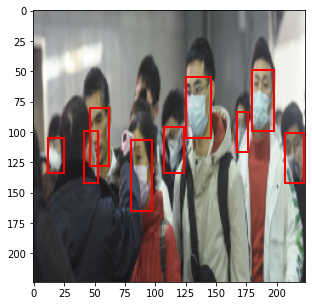

In [32]:
# Plotting bounding box on the images
img, target = dataset[1]
plot_img_bbox(img, target)

In [33]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            ToTensor() 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensor()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

# HW Test

In [35]:
file_list = os.listdir(images_dir)
len(file_list)

853

In [36]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(file_list, test_size=0.3, random_state=22)
test, val = train_test_split(test, test_size=0.666, random_state=22)
print(len(train), len(val), len(test))

597 171 85


In [37]:
# use our dataset and defined transformations
dataset = FaceMaskDataset(images_dir, annotations_dir, 480, 480, train, transforms= get_transform(train=True))
dataset_val = FaceMaskDataset(images_dir, annotations_dir, 480, 480, val, transforms= get_transform(train=False))
dataset_test = FaceMaskDataset(images_dir, annotations_dir, 480, 480, test, transforms= get_transform(train=False))

# change the dataset_test

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=10, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=2,
    collate_fn=collate_fn)

print (len(data_loader), len(data_loader_val), len(data_loader_test))

60 18 9


In [ ]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:

epochs = 2

# move model to the right device
model.to(device)
    
# parameters construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
len_dataloader = len(data_loader)

for epoch in range(epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(data_loader):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses.item()
    print('Epoch_loss = ',epoch_loss)

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

In [ ]:
# pick one image from the test set
img, target = dataset_test[80]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  5
real #boxes:  1


LABEL


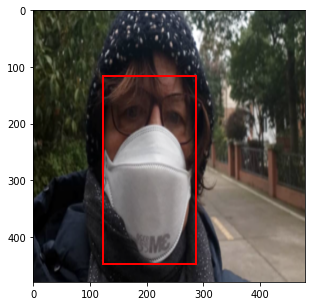

In [ ]:
print('LABEL')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


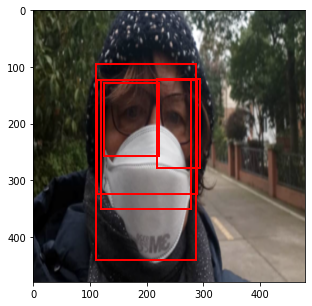

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT
Predicted NMS Labels:  3


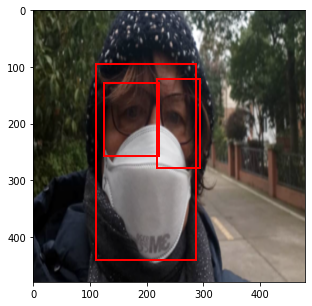

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.5) ## change iou_threshold
print('NMS APPLIED MODEL OUTPUT')
print ("Predicted NMS Labels: ",len(nms_prediction['labels']))
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
# plot

# Plot

In [ ]:
def plot_image(img_tensor, annotation,predict=True):
    
    fig,ax = plt.subplots(1)
    fig.set_size_inches(18.5, 10.5)
    img = img_tensor.cpu().data
    mask_dic = {1:'without_mask', 2:'with_mask', 3:'mask_worn_incorrectly'}

    # Display the image
    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    
    for i,box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        label = mask_dic[int(annotation['labels'][i].data)]
        if predict:
            score = int((annotation['scores'][i].data) * 100)
            ax.text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center', verticalalignment='center',fontsize=20,color='g')
        else:
            score=''
            ax.text(xmin, ymin, f"{label}", horizontalalignment='center', verticalalignment='center',fontsize=20,color='r')
    plt.show()
    

In [ ]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

model.eval()
preds = model(imgs)

print (len(imgs))

10


In [ ]:
idx = 0;
while idx < len(imgs):
    nms_prediction = apply_nms(preds[idx], iou_thresh=0.2)
    print(f'Prediction {idx+1}')
    plot_image(imgs[idx], nms_prediction)
    print(f'Target {idx+1}')
    plot_image(imgs[idx].to('cpu'), annotations[idx],False)
    
    idx = idx + 1